In [3]:
import numpy as np
import seaborn as sns
import pandas as pd
from art.attacks.evasion import FastGradientMethod
from art.attacks.evasion import ProjectedGradientDescent
from art.estimators.classification import KerasClassifier
import scvelo as scv
import cellrank as cr
from tensorflow.keras.models import Sequential
import logging
from sklearn.model_selection import train_test_split
import tensorflow as tf
import random
from matplotlib import pyplot
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
# import np_utils
from tensorflow.keras.utils import to_categorical
# from openpyxl import Workbook
from sklearn.metrics import confusion_matrix
import tensorflow
from tensorflow.python.ops.numpy_ops import np_config
np_config.enable_numpy_behavior()
tf.compat.v1.disable_eager_execution()
# modules:
from get_shap_evaluation import *
from get_intepretation import *

For the Pancreas data, you can download the file from GEO or use Scv package to read it as an object. 


In [ ]:
# After the preprocessing step and choosing the right model and architecture.
random.seed(10)
adata = cr.datasets.pancreas()
scv.pp.filter_and_normalize(adata, min_shared_counts=30, n_top_genes=2500)

cols=pd.DataFrame(adata.var)
cols=cols.index
X=pd.DataFrame.sparse.from_spmatrix(adata.X, columns=cols)
Y=(adata.obs.clusters)
Y = Y.astype(str)
X.index=Y.index
column_names = cols
classes, counts = np.unique(Y, return_counts=True)

# Encode class values as integers
encoder1 = LabelEncoder()
encoder1.fit(Y)
encodedY = encoder1.transform(Y)
dummyY = to_categorical(encodedY)
dummyY=pd.DataFrame(dummyY, index=Y.index)

original_names = [0,1,2,3,4,5,6]
new_names=["Alpha", "Beta", "Delta", "Epsilon", "Fev+", 'Ngn3 high EP', "Ngn3 low EP"]

new_columns = dict(zip(original_names, new_names))
dummyY=dummyY.rename(index=str, columns=new_columns)


lets train the cell type classifier and evaluate its performance. Selecting the proper architecture is crucial.

In [ ]:
random.seed(10)
n_inputs = X.shape[1]
X = np.asarray(X)
X_train, X_test, y_train, y_test = train_test_split(X, dummyY, test_size=0.20, random_state=10)

# build model:
Classifier_mech_noise = Sequential()
Classifier_mech_noise.add(Dense(500, input_shape=(n_inputs,), activation='relu'))
Classifier_mech_noise.add(Dropout(0.1))
Classifier_mech_noise.add(Dense(250, activation='relu'))
Classifier_mech_noise.add(Dense(100, activation='relu'))
Classifier_mech_noise.add(Dense(80, activation='relu'))
Classifier_mech_noise.add(Dense(60, activation='relu'))
Classifier_mech_noise.add(Dropout(0.2))
Classifier_mech_noise.add(Dense(40, activation='relu')) 
Classifier_mech_noise.add(Dense(20, activation='relu'))


Classifier_mech_noise.add(Dense(7, activation='softmax'))
Classifier_mech_noise.compile(loss="categorical_crossentropy", optimizer="adam", metrics=["accuracy"])
history = Classifier_mech_noise.fit(X_train, y_train, epochs=100, batch_size=500, verbose=2, validation_data=(X_test,y_test))
plt.figure(figsize=(12,8))
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

# Evaluate the classifier on the test set
yhat = Classifier_mech_noise.predict(X_test)
class_labels = np.argmax(yhat, axis=1)
y_test = np.argmax(np.array(y_test), axis=1)
cm = confusion_matrix(class_labels, y_test)
fig, ax= plt.subplots(figsize=(9,9))
sns.set(font_scale=2)
ax=sns.heatmap(cm, annot=True, fmt='g', ax=ax, xticklabels=new_names, yticklabels=new_names)
ax.figure.axes[-1].yaxis.label.set_size(15)
acc = np.sum(class_labels == y_test) / y_test.shape[0]
print("\nTest accuracy: %.2f%%" % (acc * 100))

# Implementing Adversarial Training: 
attack_type options: 'PGD', 'FGSM'.

epsilon value shows the  magnitude of the perturbation. consequently, the extent to which the adversarial example differs from the original data while remaining within a certain "epsilon-ball" around the original data point. Smaller epsilon values result in less noticeable perturbations but may be less effective at causing misclassification, while larger epsilon values can lead to more significant perturbations but may totally affect the underlying structure of the data.

The code also provides the accuracy before and after adversarial training:


In [6]:
# Adversarial training on the original data set:
def adversarial_training(Classifier_mech_noise,
                         X_test,
                         y_train,
                         y_test,
                         X_train,
                         epsilon = 1,  # Maximum perturbation
                         attack_type = 'FGSM'
                         ):
    
    '''
    Adversarial training using FGSM or PGD
    '''
    # Craft adversarial samples with FGSM or PGD
    ant_art = KerasClassifier(model=Classifier_mech_noise)
    if attack_type == 'FGSM':
        print("Adversarial Training with FGSM:\n")
        adv_crafter = FastGradientMethod(ant_art, eps=epsilon)
    elif attack_type == 'PGD':
        print("Adversarial Training with PGD:\n")
        adv_crafter = ProjectedGradientDescent(ant_art, eps= epsilon)

    x_test_adv = adv_crafter.generate(x=np.array(X_test))
    x_train_adv = adv_crafter.generate(x=np.array(X_train))
    
    
    # Evaluate the classifier on the adversarial examples
    preds = np.argmax(ant_art.predict(x_test_adv), axis=1)
    acc_adv = np.sum(preds == y_test) / y_test.shape[0]
    print("\nTest accuracy on adversarial sample: %.2f%%" % (acc_adv * 100))
    
    #update input:
    logger = logging.getLogger()
    logger.setLevel(logging.INFO)
    handler = logging.StreamHandler()
    formatter = logging.Formatter("[%(levelname)s] %(message)s")
    handler.setFormatter(formatter)
    logger.addHandler(handler)

    #updated input:
    x_train_adv = np.append(X_train, x_train_adv, axis=0)
    y_train_adv = np.append(y_train, y_train, axis=0)
    
    history = Classifier_mech_noise.fit(x_train_adv, y_train_adv, epochs=100, batch_size=500)

    # Evaluate the adversarially trained classifier on the test set
    preds = np.argmax(Classifier_mech_noise.predict(x_test_adv), axis=1)
    acc = np.sum(preds == y_test) / y_test.shape[0]
    logger.info("Classifier with adversarial training")
    logger.info("Accuracy on adversarial samples: %.2f%%", (acc * 100))
     
    return Classifier_mech_noise, x_train_adv, y_train_adv, x_test_adv

In [ ]:
Classifier_mech_noise_adv, x_train_adv, y_train_adv, x_test_adv = adversarial_training(Classifier_mech_noise,
                            X_test,
                            y_train,
                            y_test,
                            X_train,
                            epsilon = 1.5 , # Maximum perturbation
                            attack_type = 'FGSM'
                            )

# Interpretability of the trained model:


Here we used different interpretability methods. You have the option to select from six different interpretability methods if you do not wish to run all of them to compute the final importance consensus score. 

Below we calculate SHAP values to interpret the predictions made by the trained model, providing insights into feature contributions and their impact on individual predictions.

In [1]:
def get_most_important_genes(
                             shap_values,
                             background,
                             shap_method,
                             X_test,
                             Y,
                             column_names,
                             master_regulators,
                             number_of_genes_to_check = 500
                             ):
    
    '''
    Find most important genes based on the shap values
    '''
       
    deep_shap_dict_all = {key: None for key in np.unique(Y)}
    
    number_of_classes = len(np.unique(Y))
    
    #get most important features from last part:
    for i in range(0,number_of_classes):
        
        vals = np.abs(shap_values[i]).mean(0)
    
        feature_importance = pd.DataFrame(list(zip(column_names, vals)), columns=['col_name','feature_importance_vals'])
        # feature_importance.iloc[:,0] = feature_importance.iloc[:,0].str.extract('(\d+)').astype(int)
    
        feature_importance.sort_values(by=['feature_importance_vals'], ascending=False, inplace=True)
        deep_shap_class = feature_importance[:]
        
        deep_shap_dict_all[np.unique(Y)[i]] = deep_shap_class[:]
         
    output = open('shap_genes_normal_{}.pkl'.format(shap_method), 'wb')
    pickle.dump(deep_shap_dict_all, output)
    output.close()
    
    return deep_shap_dict_all, feature_importance, shap_values


def get_shap_values(
                    Classifier,
                    background,
                    X,
                    X_test,
                    Y,
                    column_names,
                    master_regulators,
                    shap_method = ['Deep', 'Kern', 'Gradiant'],
                    number_of_genes_to_check = 500
                    ):
    '''
    Gets shap values based on method and background
    outputs: shap plots and feature importances
    
    '''
    deep_shap_dict_all_all_methods = []
    common_w_master_regulators_percent_all_dshap_all_methods = []
    
    shap_values_all_methods = []
    feature_importance_all_methods = []
    
    for method in shap_method:
        if  method =='Deep':
            e = shap.DeepExplainer(Classifier, background)
        elif method == 'Kern':
            e =  shap.SamplingExplainer(Classifier.predict, background)
        elif method == 'Gradiant':
            e = shap.GradientExplainer(Classifier, background)

        # get just the explanations for the positive class
        shap_values = e.shap_values(X_test)
    
        # shap.summary_plot(shap_values[0], X_test, plot_type = 'dot', feature_names =column_names, show=False)
        # ax = plt.gca()
        # ax.set_xlim(-0.1, 0.1) 
        # plt.savefig("shap_normal_dot_{}.png".format(method), bbox_inches='tight', dpi = 300)
        # shap.summary_plot(shap_values[0], plot_type = 'bar', feature_names =column_names,show=False)
        # ax = plt.gca()
        # plt.savefig("shap_normal_bar_{}.png".format(method), bbox_inches='tight', dpi = 300)
        # plt.show()

        shap.summary_plot(shap_values,X_test,feature_names=column_names)
                
        # feature importances
        vals = np.abs(shap_values[0]).mean(0)
        
        feature_importance = pd.DataFrame(list(zip(column_names, vals)),
                                         columns=['col_name','feature_importance_vals'])
        feature_importance.sort_values(by=['feature_importance_vals'],
                                      ascending=False, inplace=True)
        feature_importance.head()
        
        
        # get most important genes based on shap values:
        deep_shap_dict_all, feature_importance, shap_values = get_most_important_genes( 
                        
                                     shap_values,
                                     background,
                                     method,
                                     X_test,
                                     Y,
                                     column_names,
                                     master_regulators,
                                     number_of_genes_to_check = number_of_genes_to_check
                                     
                                     )
        
        deep_shap_dict_all_all_methods.append(deep_shap_dict_all)        
        shap_values_all_methods.append(shap_values)
        feature_importance_all_methods.append(feature_importance)
    
    return deep_shap_dict_all_all_methods,feature_importance_all_methods, shap_values_all_methods

keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


[WARNING] From C:\Users\mehrs\anaconda3\envs\shire\lib\site-packages\shap\explainers\tf_utils.py:29: The name tf.keras.backend.get_session is deprecated. Please use tf.compat.v1.keras.backend.get_session instead.



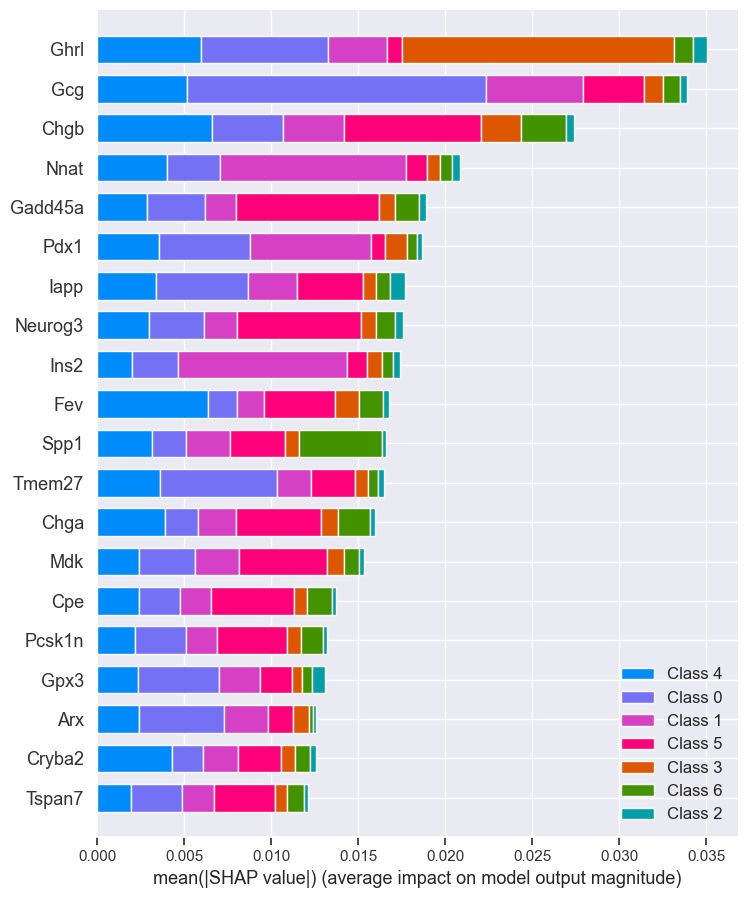

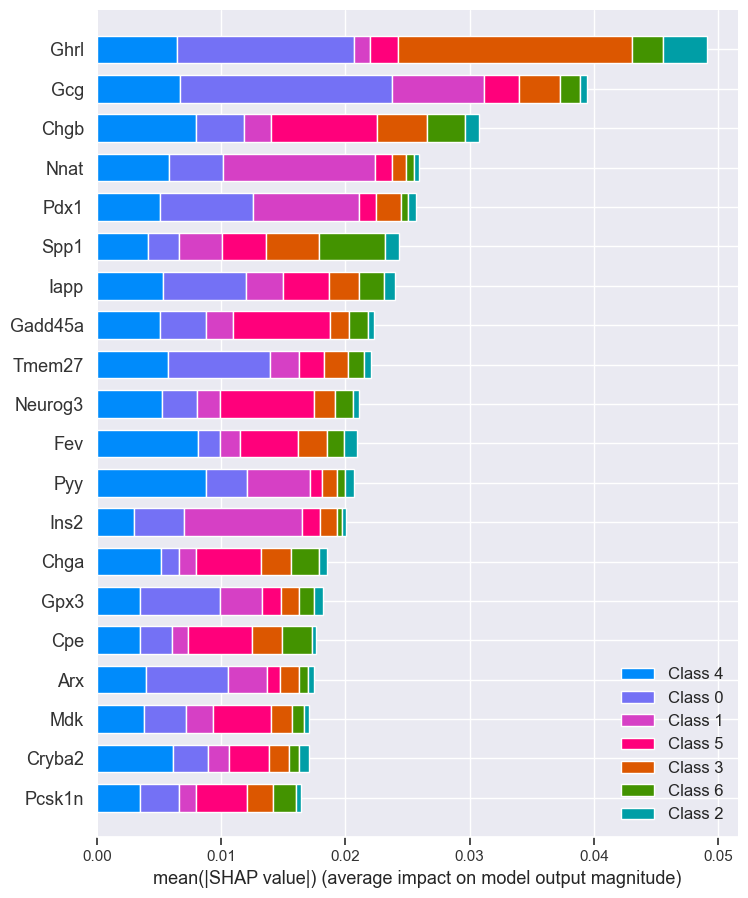

In [9]:
number_of_genes_to_check = 500
# background = X_train[np.random.choice(X_train.shape[0], 5, replace=False)]
background = X_train[np.random.choice(pd.DataFrame(X_train).index, 500, replace=False)]


[most_important_shap_features_all,
feature_importance_all_methods,
shap_values_all_methods] = get_shap_values(
                    Classifier_mech_noise_adv,
                    background,
                    X,
                    X_test,
                    Y,
                    column_names,
                    master_regulators,
                    shap_method = ['Deep', 'Gradiant', 'Kern'],
                    number_of_genes_to_check = number_of_genes_to_check
                    )


Here we perform activation maximization to enhance the interpretability of the method by understanding what input patterns or features maximize the activation of specific neurons or units within the model.

In [10]:
def my_activation_maximization(myModel, class_idx):    

    input_vec = myModel.input
    output_vec = myModel.output[:,class_idx]
    
    # Loss is defined according to the class we want to maximize:
    loss = K.mean(myModel.output[:,class_idx]) 
        
    # Compute the gradient of the loss w.r.t the input vector + normalize to avoid very small/large gradients:
    grads = K.gradients(loss, input_vec)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Calculate the loss and grads given the input vector:
    iterate = K.function([input_vec], [loss,grads])

    # Start gradient ascent from a random input vector:
    rand_vec = np.random.random((1, input_vec.shape[1]))
    
    # Gradient ascent:
    alpha = 0.1
    num_steps = 5
    for i in range(num_steps):
        loss_value, grads_value = iterate([rand_vec])
        rand_vec += grads_value*1.
        
    rand_vec = np.transpose(rand_vec)
    
    return rand_vec

def get_top_genes_all_cells_am(act_max,
                           n = 20):
    '''
    based on AM find the most important genes of each group
    '''

    
    cell_types = act_max.columns[1:]
    top_genes = pd.DataFrame( columns = cell_types )
    act_max_abs = abs(act_max.iloc[:,1:])
    act_max_abs.insert(0,'Gene',act_max.iloc[:,0] )

    for cell_type in cell_types:
        top_genes.loc[:,cell_type] = act_max_abs.sort_values(cell_type, ascending=False).reset_index().Gene[:n]
    return top_genes

Lets draw a heatmap with the computed AM scores

Alpha
Beta
Delta
Epsilon
Fev+
Ngn3 high EP
Ngn3 low EP


<Axes: xlabel='Gene'>

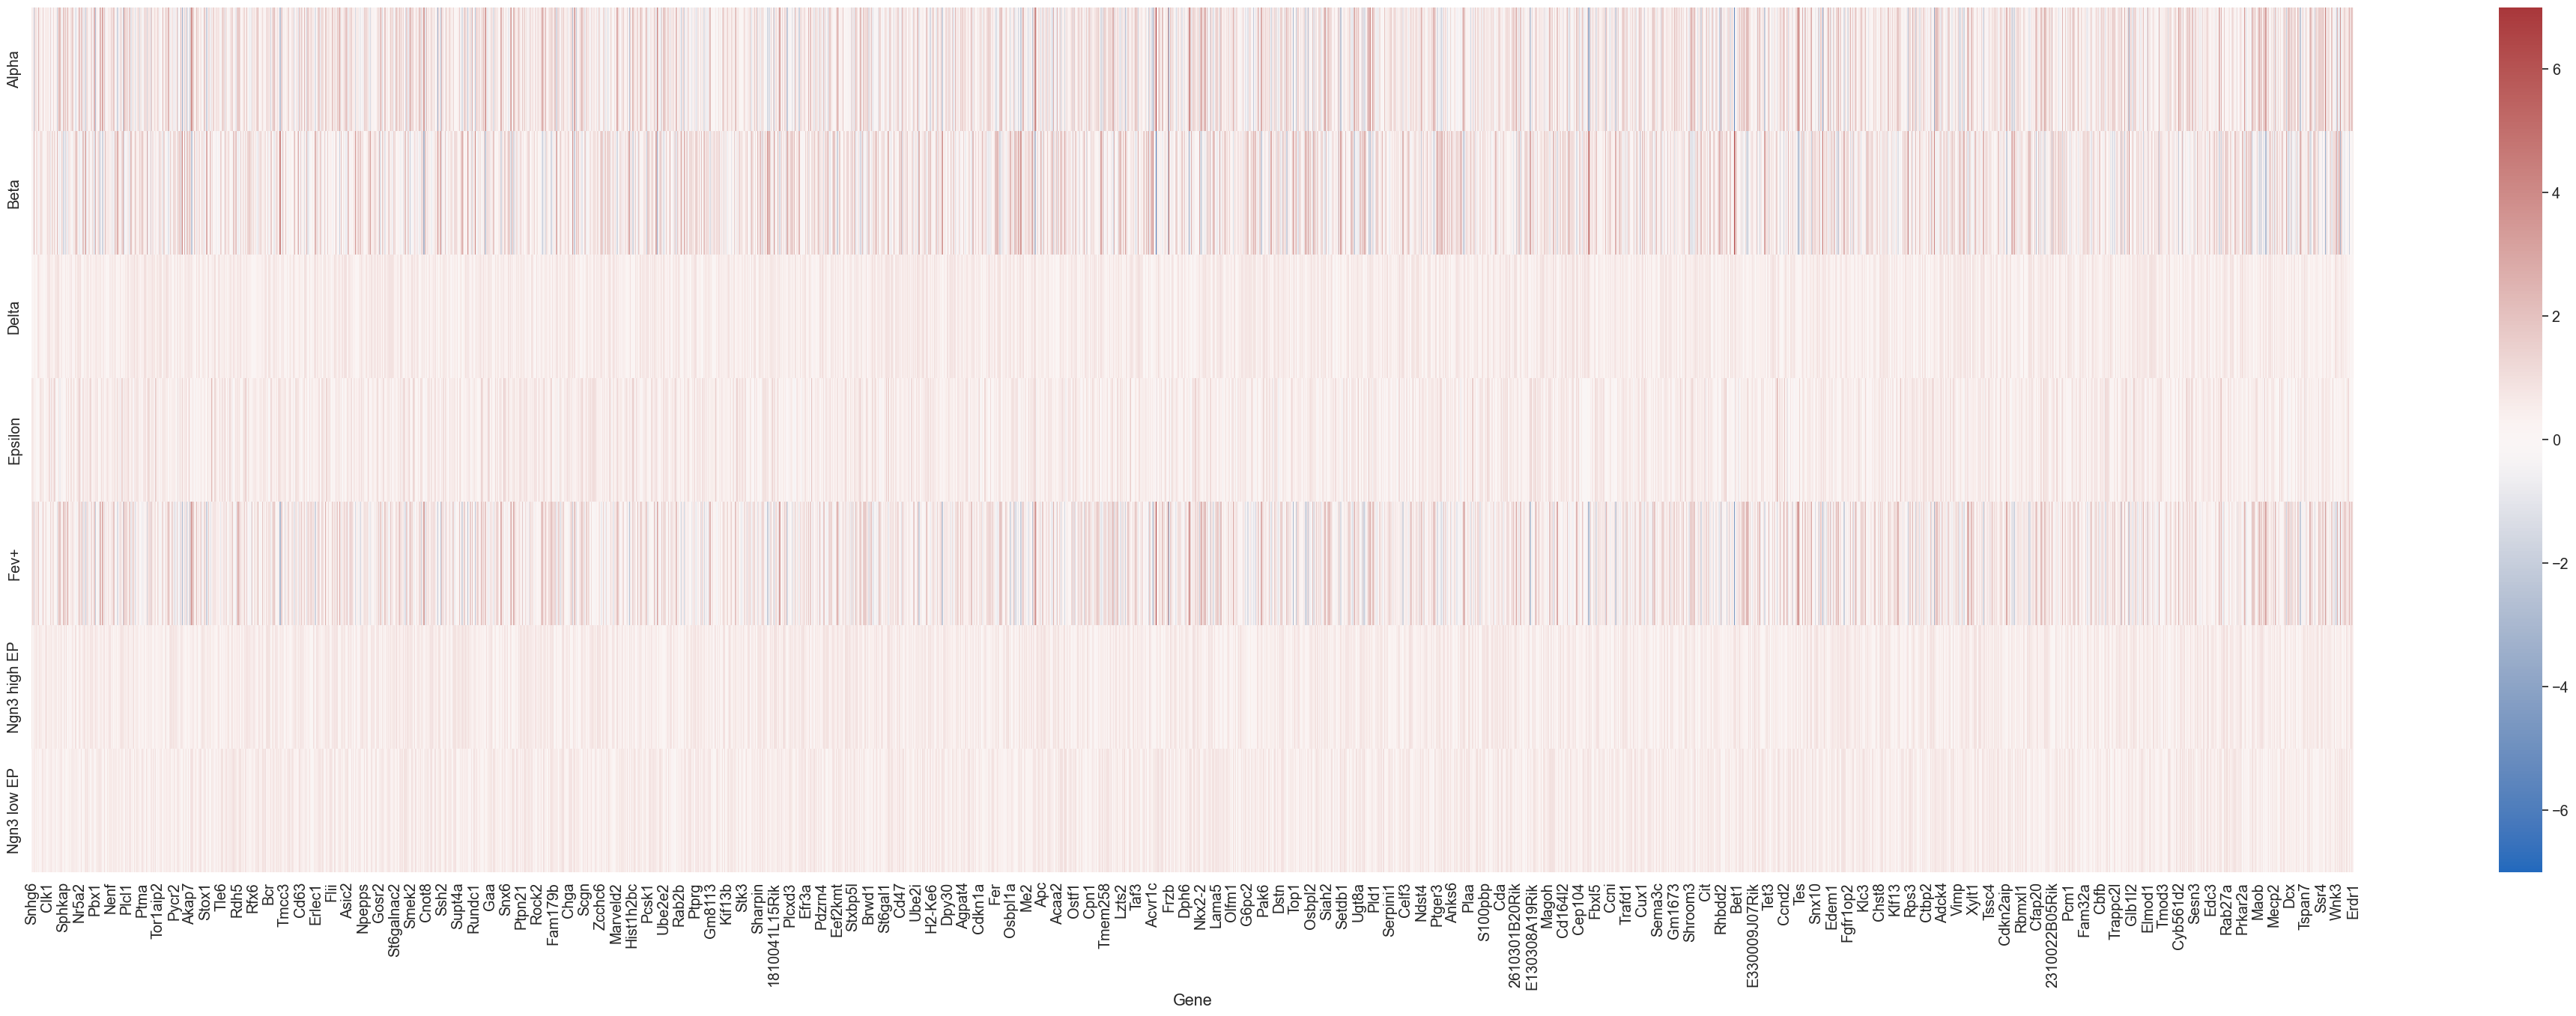

In [11]:
# Create a dataframe of activation maximization scores of size num_genes X num_classes:
genes = column_names[:] 
act_max =  pd.DataFrame(genes.values, columns=['Gene'])

# Computing activation maximization for each class:
class_idx = 0
for class_label in np.unique(Y): 
    print(class_label)
    
    act_max[class_label] = my_activation_maximization(Classifier_mech_noise_adv, class_idx)        
    class_idx+=1

# Get most important genes from activation maximization:
feature_importance_am = get_top_genes_all_cells_am(act_max,
                           n = number_of_genes_to_check)

act_max2=act_max.set_index("Gene")
sns.set(font_scale=1.3)
fig,ax1 = plt.subplots(figsize=(50,15))
sns.heatmap(np.transpose(act_max2.iloc[:,0:]),cmap="vlag", ax=ax1, vmin=-7, vmax=7, yticklabels=True)

In [ ]:
import multiprocessing
def my_saliency_map(Mymodel,class_idx, sample_vec):    
    input_vec = Mymodel.input
    output_vec = Mymodel.output[:, class_idx]    
    
    # Loss is defined according to the class we want to maximize:
    loss = K.mean(Mymodel.output[:, class_idx])  
 
    # Compute the gradient of the output vector w.r.t the input vector + normalize to avoid very small/large gradients:
    grads = K.gradients(output_vec, input_vec)[0]
    grads /= (K.sqrt(K.mean(K.square(grads))) + 1e-5)
    
    # Calculate the loss and grads given the input vector:
    iterate = K.function([input_vec], [loss,grads])

    # Gradient descent on the given sample_vec:
    alpha = 0.1
    num_steps = 1
    
    sample_vec = sample_vec.reshape(1,n_inputs)
    for i in range(num_steps):
        loss_value, grads_value = iterate([sample_vec])
        grads_value -= grads_value*alpha
    
    return grads_value[0]

# Create dataframes of gene expression and saliency maps of size num_genes X num_samples:
genes = mechanistic_model.columns.values.tolist()
expression_all_samples =  pd.DataFrame(genes, columns=['Gene'])
saliency_all_samples =  pd.DataFrame(genes, columns=['Gene'])
# Create a dataframe of averaged saliency maps of size num_genes X num_classes:
saliency_average_samples = pd.DataFrame(genes, columns=['Gene'])

x_train = X
class_idx=0
for class_label in np.unique(Y): 
    #print(class_label)
    i=0
    class_samples_indices = np.where(encodedY==class_idx)[0]
    np.random.shuffle(class_samples_indices)   
    num_class_samples = len(class_samples_indices)
    #print(num_class_samples)
    
    class_expression = pd.DataFrame(np.zeros((n_inputs, num_class_samples)),columns=[str(class_label) + '_' + str(x) for x in range(num_class_samples)])
    class_saliency = pd.DataFrame(np.zeros((n_inputs, num_class_samples)),columns=[str(class_label) + '_' + str(x) for x in range(num_class_samples)])
    
    for sample_idx in class_samples_indices:       
        sample_vec = x_train[:][sample_idx]
        class_expression.iloc[:,i] = sample_vec
        # pool = multiprocessing.Pool()
        # l=((class_idx,sample_vec))
        # saliency_vec = pool.map(my_saliency_map, l)
        saliency_vec = my_saliency_map(Classifier_mech_noise, class_idx, sample_vec)
        class_saliency.iloc[:,i] = saliency_vec
        i+=1
        #print(i)
    
    expression_all_samples = expression_all_samples.join(class_expression)
    saliency_all_samples = saliency_all_samples.join(class_saliency)
    saliency_average_samples[class_label] = np.mean(class_saliency,axis=1)

    class_saliency = saliency_all_samples['Gene'].to_frame().join(class_saliency)   
    # class_saliency.to_excel(writer,class_label)
    # writer.save()
        
    class_idx+=1


We also compute LIME (Local Interpretable Model-agnostic Explanations) to explain the behavior of the method by approximating its predictions on specific instances, 
focusing model interpretability on a local level.



In [ ]:
# Lime Method:
import lime
import lime.lime_tabular
import time
start = time.time()

e_lime = lime.lime_tabular.LimeTabularExplainer(
                            x_train_adv, feature_names=column_names, 
                            class_names=Y.unique(), discretize_continuous=True
                            )

# get most important genes based on Lime
# find local important genes for each class and aggregate over all of them

lime_important_features_all_all = []
lime_important_features_all_all_genes = []
for i in range(len(np.unique(Y))):
    
    # find all the test samples of each class:
    important_features_class_all = []
    class_indx = np.where(y_test == i)
    X_test_class = X_test[class_indx]

    # get all important genes using lime for each test sample of the class:
    for j in range(len(X_test_class)):
        # double check this part with top_labels and num_features ** change number of samples too **
        exp = e_lime.explain_instance(X_test_class[j], Classifier_mech_noise_adv.predict, num_features=len(column_names[:]),
                                      top_labels=number_of_genes_to_check, num_samples=500)
        '''
        Make num_sample = 100 or more
        '''
        print("j:",j)
        outputs = exp.as_map()
        for k in range(number_of_genes_to_check):
            important_features_class_all.append(outputs[i][k][0])

    # find most repeates genes of the specific class:
    count_repeats_class = dict((i, important_features_class_all.count(i)) for i in important_features_class_all)
    count_repeats_class = sorted(count_repeats_class.items(), key=lambda x: x[1], reverse=True)[:number_of_genes_to_check]
    
    # select the most repeated ones:
    count_repeats_class_top = []
    for m in range(number_of_genes_to_check):
        count_repeats_class_top.append(count_repeats_class[m][0])

    # append for each class:
    lime_important_features_all_all.append(count_repeats_class_top)

    # change index to gene names:
for m in range(len(lime_important_features_all_all)):
    lime_important_features_all_all_genes.append(list((column_names[lime_important_features_all_all[m]])))
    
end = time.time()
print(end - start)      

Computing the consensus importance score. You have the option to select from the six different interpretability methods if you do not wish to run all of them.

In [15]:
# get majority vote:
shap_method = ['Deep', 'Gradiant', 'Kern']

all_methods_all_important_genes = []

ys = np.unique(Y)

for j in range(len(np.unique(Y))):
    get_imp_genes_method = []
    # shap methods:
    for i in range(len(shap_method)):
        get_imp_genes_method = get_imp_genes_method + list(most_important_shap_features_all[i][ys[j]][:number_of_genes_to_check].col_name.values)

    # activation maximization:
    get_imp_genes_method = get_imp_genes_method + list(feature_importance_am.iloc[j].values)

    # lime:
    get_imp_genes_method = get_imp_genes_method + lime_important_features_all_all_genes[j]

    # Saliency:
    get_imp_genes_method = get_imp_genes_method + class_saliency[j]
    #get_imp_genes_method = get_imp_genes_method + list(class_saliency.iloc[:,j].values)


    
    all_methods_all_important_genes.append(get_imp_genes_method)


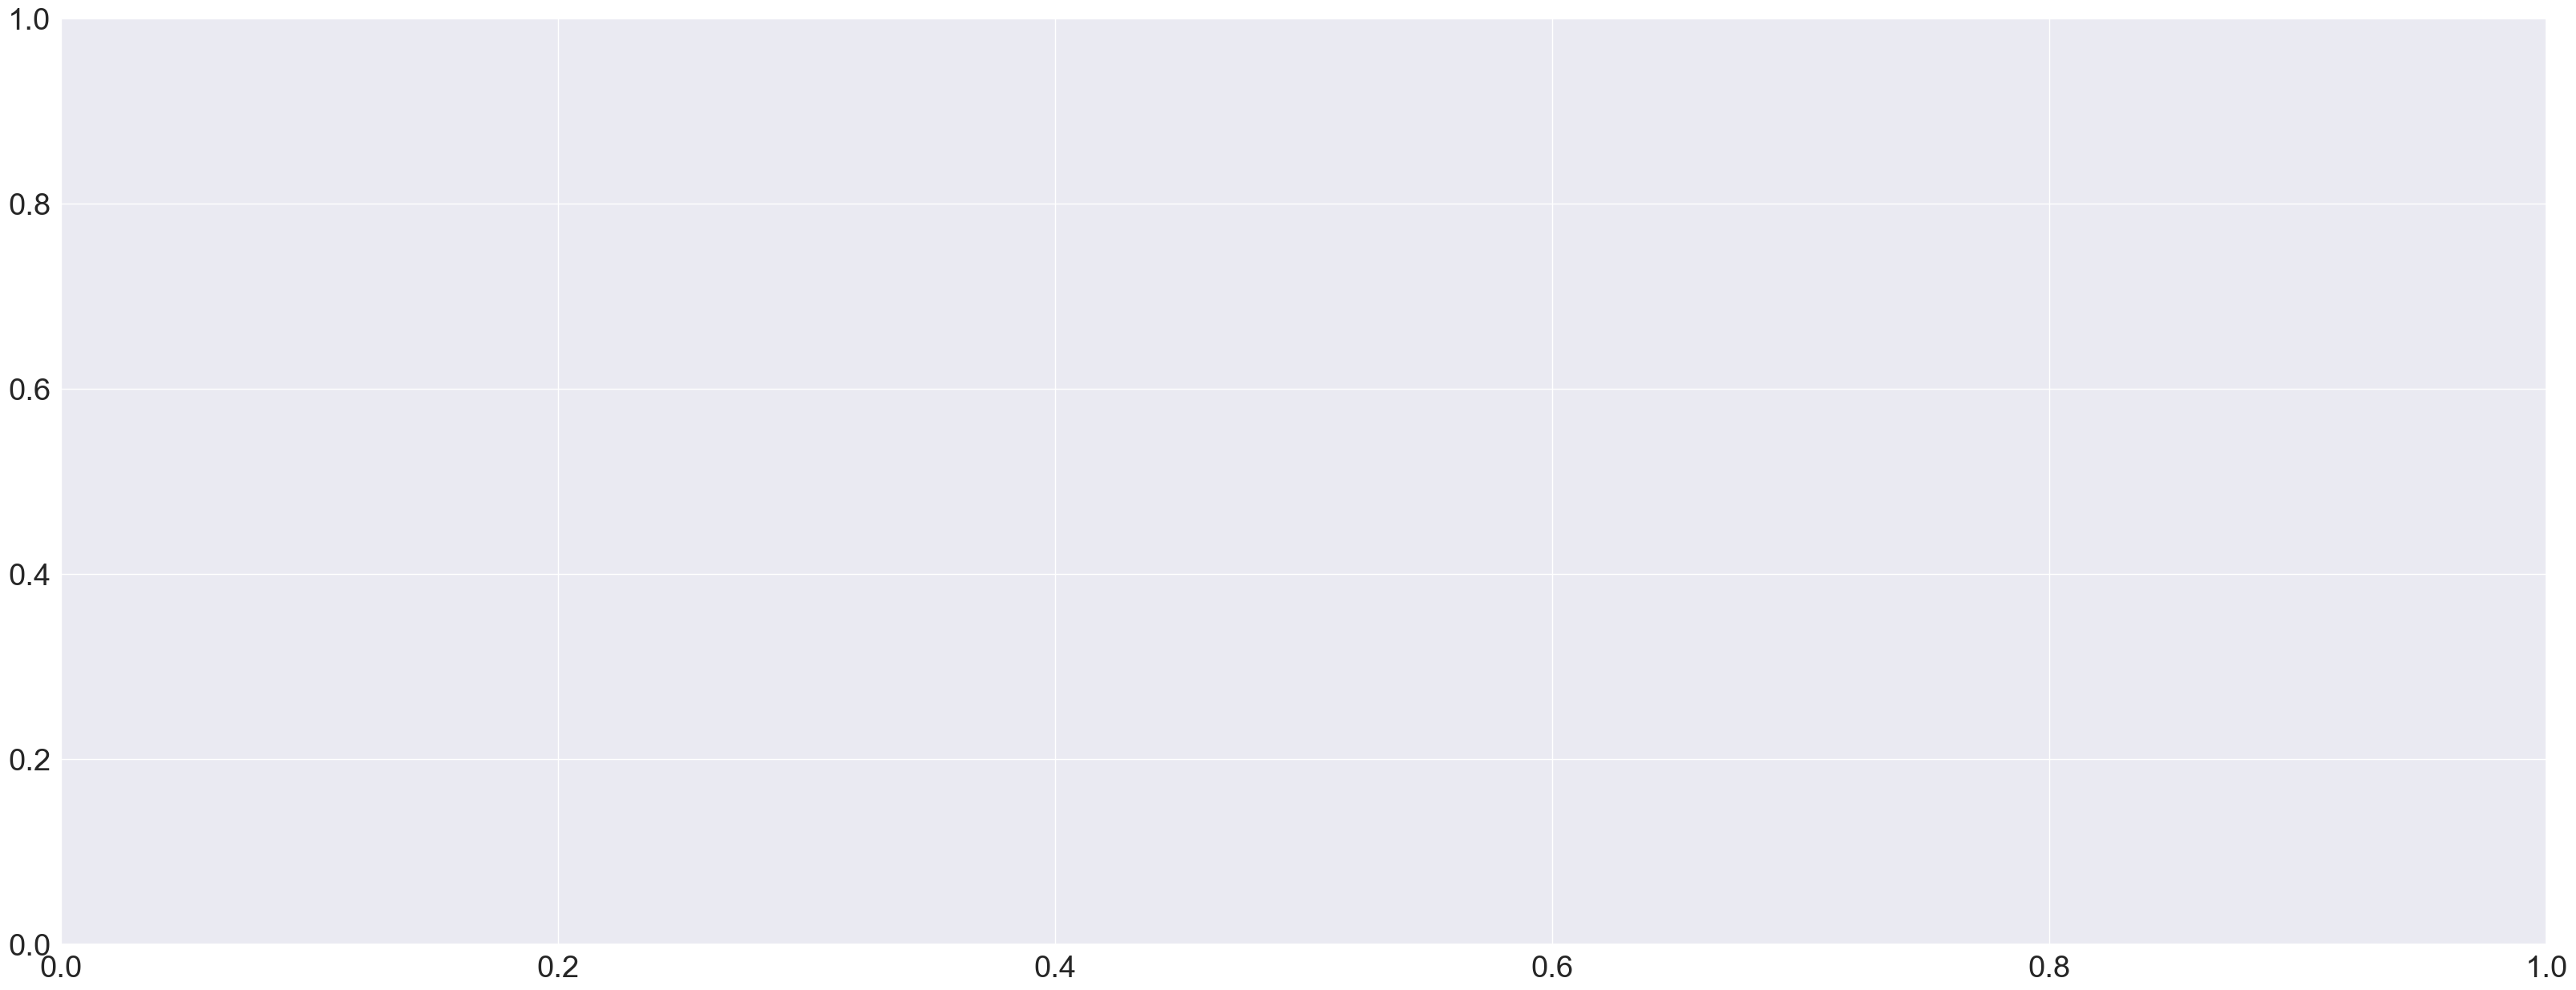

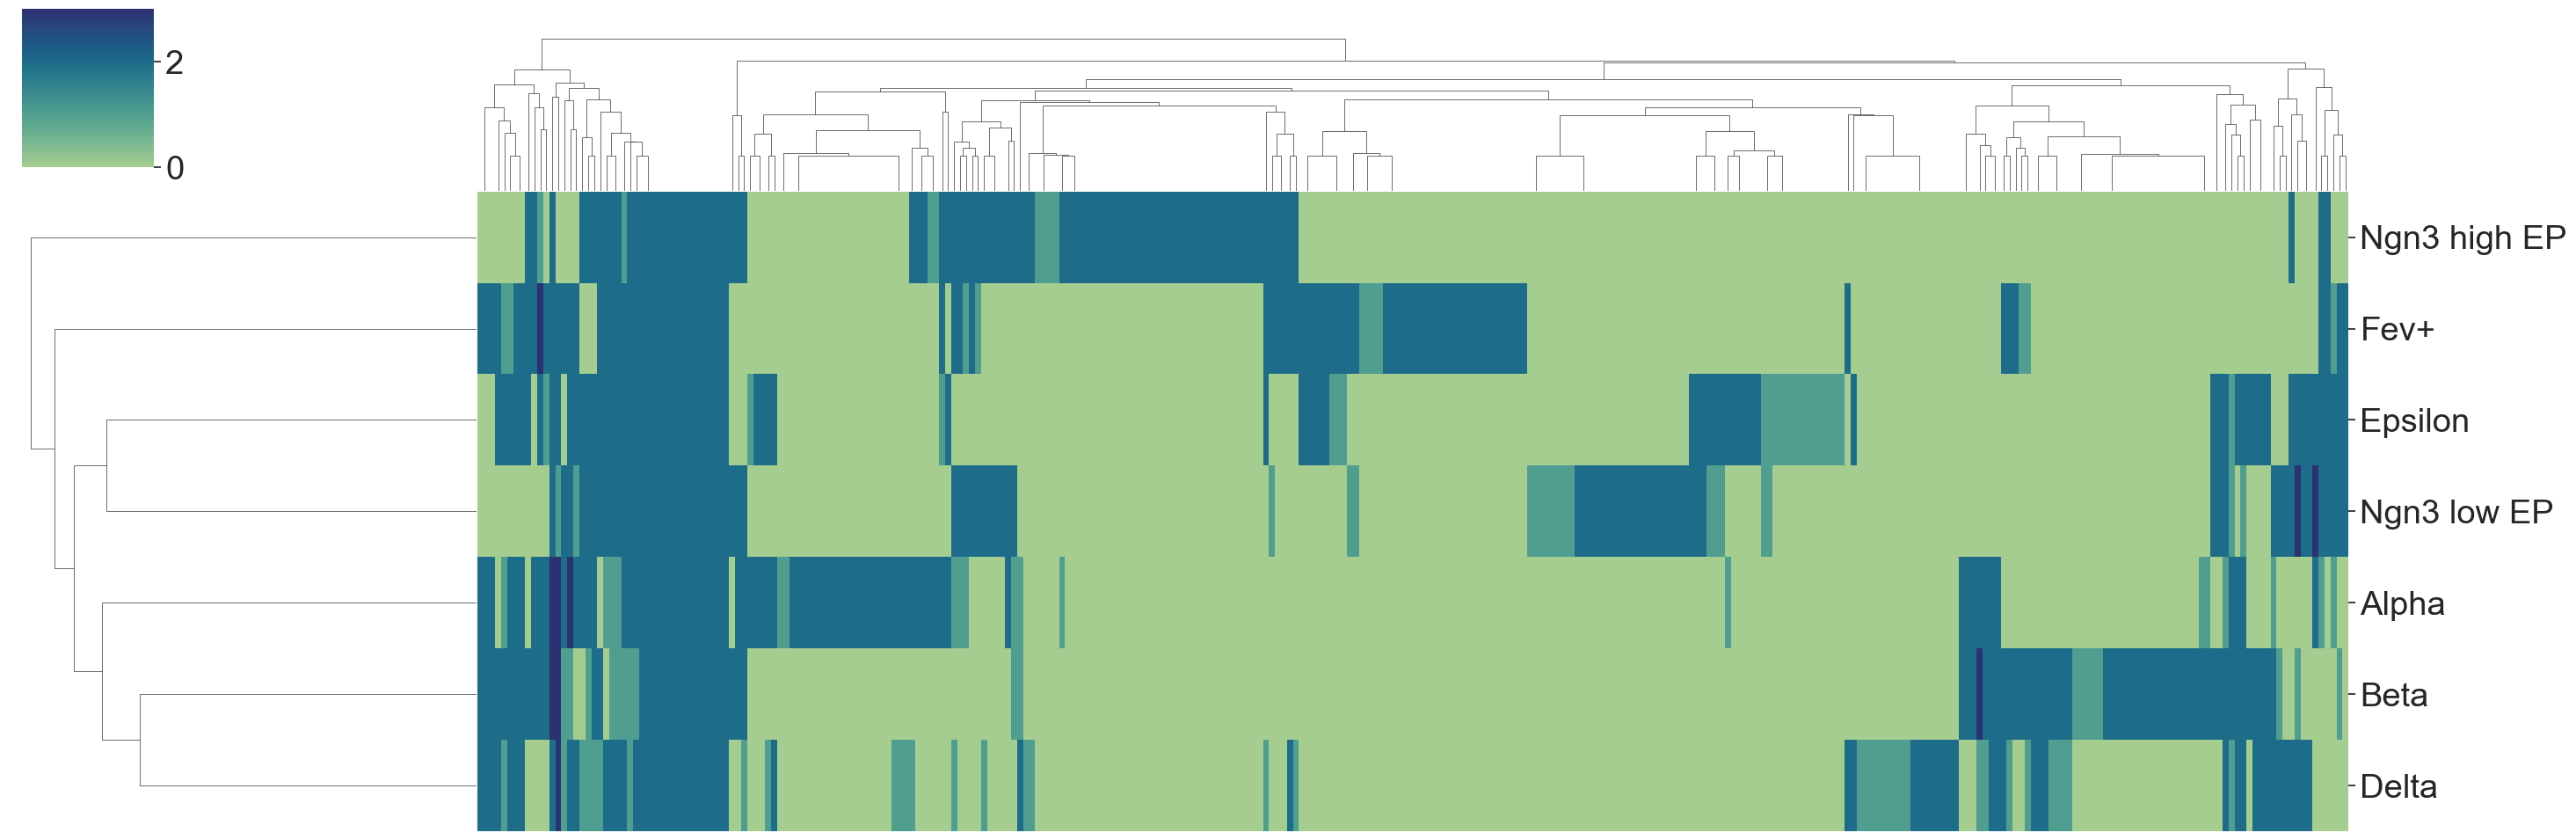

In [17]:
# calcualte the most repeated genes for each group:
count_repeats_all_all = []
for j in range(len(np.unique(Y))):
    count_repeats_all_class = []
    count_repeats_all = dict((i, all_methods_all_important_genes[j].count(i)) for i in all_methods_all_important_genes[j])
    count_repeats_all = sorted(count_repeats_all.items(), key=lambda x: x[1], reverse=True)[:number_of_genes_to_check]

    #for m in range(number_of_genes_to_check):
    #    count_repeats_all_class.append(count_repeats_all[m][0])
    count_repeats_all_all.append(count_repeats_all)



new_names=["Alpha", "Beta", "Delta", "Epsilon", "Fev+", 'Ngn3 high EP', "Ngn3 low EP"]

a=pd.DataFrame(count_repeats_all_all[0], columns =['Gene_Alpha', 'Alpha'])
a = a.set_index(["Gene_Alpha"])

b=pd.DataFrame(count_repeats_all_all[1], columns =['Gene_Beta', 'Beta'])
b = b.set_index(["Gene_Beta"])

c=pd.DataFrame(count_repeats_all_all[2], columns =['Gene_Delta', 'Delta'])
c = c.set_index(["Gene_Delta"])

d=pd.DataFrame(count_repeats_all_all[3], columns =['Gene_Epsilon', 'Epsilon'])
d = d.set_index(["Gene_Epsilon"])

e=pd.DataFrame(count_repeats_all_all[4], columns =['Gene_Fev+', 'Fev+'])
e = e.set_index(["Gene_Fev+"])

f=pd.DataFrame(count_repeats_all_all[5], columns =['Gene_Ngn3 high EP', 'Ngn3 high EP'])
f = f.set_index(["Gene_Ngn3 high EP"])

g=pd.DataFrame(count_repeats_all_all[6], columns =['Gene_Ngn3 low EP', 'Ngn3 low EP'])
g = g.set_index(["Gene_Ngn3 low EP"])

from functools import partial, reduce
koli=pd.concat([a,b,c,d,e,f,g], axis=1)
koli=koli.fillna(0)

pd.DataFrame(koli).to_csv("panc_import.csv")

sns.set(font_scale=2.5)
fig,ax1 = plt.subplots(figsize=(40,15))
sns.clustermap(np.transpose(koli.iloc[:,0:]),cmap="crest", vmin=0, vmax=3, yticklabels=True,  xticklabels=False, figsize=(30,10))
